#Homework 3: Gradien Descent and Model (parameters/features) Selection (20pt)

In [245]:
#from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
#from matplotlib import cm
#%matplotlib inline
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from IPython.display import clear_output
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import SGDRegressor, Lasso, Ridge, ARDRegression, ElasticNet, HuberRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression, r_regression, f_regression
from sklearn.pipeline import Pipeline, make_pipeline

%matplotlib inline

### Download the dataset from class, missing values imputed for you

In [246]:
Data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
                    header=None, na_values=["?"])
Data.dropna(subset=Data.columns[Data.columns != 1], inplace=True)
imputer = SimpleImputer()
Data[1] = imputer.fit_transform(Data[[1]])

In [247]:
#pd.set_option('display.max_columns', None)
Data.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,3,121.132075,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,121.132075,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,121.132075,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.000000,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.000000,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


We itroduced Stochastic Gradien Descent algorithm:

1) Initialize randomly weights $w=(w_0, w_1, \ldots, w_d)$

2) Take a point $x^{(i)}=(x_0^{(i)}, x_1^{(i)}, \ldots, x_d^{(i)})$ with $x_0^{(i)}=1$

3) Calculate error (MSE) on it:
$$Loss(a(x^{(i)}), y^{(i)}) = (w^Tx^{(i)} - y^{(i)})^2$$

4) Calculate gradient of the loss function:
$$\nabla Loss(a(x^{(i)}), y^{(i)}) = 2x^{(i)}(w^Tx^{(i)} - y^{(i)})\qquad (*)$$

5) Update weights:
$$
w^{new} = w^{old} - \nabla Loss(a(x^{(i)}), y^{(i)})
$$

*Derivation of the expression $(*)$.* The loss function looks as follows:
$$Loss(a(x^{(i)}), y^{(i)})=(w_0x_0^{(i)}+w_1x_1^{(i)}+\ldots+w_dx_d^{(i)} - y^{(i)})^2$$
Gradient is a vector of derivatives with respect to every $w_j:$
$$\nabla (w_0x_0^{(i)}+w_1x_1^{(i)}+\ldots+w_dx_d^{(i)} - y^{(i)})^2
= \begin{pmatrix}2x_0^{(i)}(w_0x_0^{(i)}+w_1x_1^{(i)} + \ldots +w_dx_d^{(i)} - y^{(i)}) \\ 2x_1^{(i)}(w_0x_0^{(i)}+w_1x_1^{(i)} + \ldots +w_dx_d^{(i)} - y^{(i)})\\ \vdots \\ 2x_d^{(i)}(w_0x_0^{(i)}+w_1x_1^{(i)}+\ldots+w_dx_d^{(i)} - y^{(i)})\end{pmatrix}$$
$$= \begin{pmatrix}2x_0^{(i)} \\ 2x_1^{(i)}\\ \vdots \\ 2x_d^{(i)}\end{pmatrix} (w_0x_0^{(i)}+w_1x_1^{(i)}+\ldots+w_dx_d^{(i)} - y^{(i)}) =2x^{(i)}(w^Tx^{(i)} - y^{(i)})$$

#1. (7pt) A class with realization of SGD algorithm is provided below. There is a parameter *batch_size=1.* You are asked to add code, such that for *batch_size=B>1* it performes mini-batch SGD and for *batch_size=0* it peformes standard Gradient Descent using full batch.  

Do not use $sum()$ at all. For example, to compute the loss over all the data, we use matrix nodation
$$
\sum_{i=1}^{N}(w^Tx^{(i)}-y^{(i)})^2=\frac{1}{N}(Xw-y)^T(Xw-y)
$$
that can be coded as *(X.dot(w)-y).dot(X.dot(w)-y)/len(y)*.

You can get some ideas from [the class notebook](https://github.com/anton-selitskiy/RIT_ML/blob/main/SGD.ipynb)

In [248]:
class SGD():
  def __init__(self, batch_size=1, lr=1e-3, max_epoch=100):
    self.batch_size = batch_size
    self.lr = lr
    self.max_epoch = max_epoch


  def loss(self, x, y):
    return (x.dot(self.w)-y)**2

  def loss_grad(self, x, y):
    # return 2*x*(x.dot(self.w)-y)
    return 2*(x*(self.w)-y)

  def batch_loss(self, X, y):
    #your code here
    return np.mean((X.dot(self.w) - y) ** 2)

  def batch_loss_grad(self, X, y):
    #your code here
    return 2 * X.T.dot(X.dot(self.w) - y) / len(y)

  def fit(self, X, y):
    self.X = np.hstack((np.ones((len(X),1)),X.values))
    self.y = y.values
    self.w = np.random.rand(self.X.shape[1])
    for epoch in range(self.max_epoch):
      if self.batch_size == 1:
        for i in range(len(self.X)):
          self.w -= self.lr*self.loss_grad(self.X[i,:], self.y[i])
      elif self.batch_size == 0:
        # for batch_size == 0 we do standard gradient descent with full batch
        self.w -= self.lr * self.batch_loss_grad(self.X, self.y)


      elif self.batch_size > 1:
        # for batch_size > 1 we do standard gradient descent with mini-batch
        for i in range(0, len(self.X), self.batch_size):
          X_batch = self.X[i:i+self.batch_size]
          y_batch = self.y[i:i+self.batch_size]
          self.w -= self.lr * self.batch_loss_grad(X_batch, y_batch)

      # # Uncomment for Visualisation
      # if (epoch + 1) % 10 == 0:
      #   clear_output(True)
      #   plt.figure(figsize=(10,8))
      #   plt.scatter(self.X[:,1], self.y, label="data")
      #   plt.scatter(self.X[:,1], self.X.dot(self.w), color="orange", linewidth=5, label="predictions")
      #   plt.xlabel("Feature 13", fontsize=14)
      #   plt.ylabel("Car Price", fontsize=14)
      #   plt.title(f"SGD batch size = {self.batch_size}, epoch = {epoch}, lr={self.lr}, RMSE={np.sqrt(sgd.batch_loss(sgd.X,sgd.y))}", fontsize=18)
      #   plt.legend(fontsize=14)
      #   plt.show()

#2. (3pt) Run this class with the following parameters:

max_epochs = 100 and 1000

batch_size = 0, 1, 10, 50

lr = 1e-6, 1e-7, 1e-8

Report the results (RMSE) and try to explain how batch size coordinates with the learning rate.

In [249]:
np.random.seed(42)

In [250]:
import itertools
# Define three parameter lists
epoch_list = [100, 1000]
batch_list = [0, 1, 10 ,50]
lir_list = [1e-6, 1e-7, 1e-8]

# Generate all permutations of the parameter lists
all_permutations = list(itertools.product(epoch_list, batch_list, lir_list))

# Print all permutations
for perm in all_permutations:
    sgd = SGD(max_epoch=perm[0], lr=perm[2], batch_size=perm[1])
    sgd.fit(Data[[13]],Data[25])
    print(f"Permutation: {perm}, RMSE: {np.sqrt(sgd.batch_loss(sgd.X,sgd.y))}")

Permutation: (100, 0, 1e-06), RMSE: 2.3350844776121255e+114
Permutation: (100, 0, 1e-07), RMSE: 5928.020141018782
Permutation: (100, 0, 1e-08), RMSE: 5927.945276622044
Permutation: (100, 1, 1e-06), RMSE: 6025.954865600116
Permutation: (100, 1, 1e-07), RMSE: 5987.031908836134
Permutation: (100, 1, 1e-08), RMSE: 7694.967380456467
Permutation: (100, 10, 1e-06), RMSE: nan
Permutation: (100, 10, 1e-07), RMSE: 8582.7583477346


<ipython-input-248-3b6f13e0bc3e>:41: RuntimeWarning: invalid value encountered in subtract
  self.w -= self.lr * self.batch_loss_grad(X_batch, y_batch)
<ipython-input-248-3b6f13e0bc3e>:21: RuntimeWarning: overflow encountered in multiply
  return 2 * X.T.dot(X.dot(self.w) - y) / len(y)
<ipython-input-248-3b6f13e0bc3e>:41: RuntimeWarning: invalid value encountered in subtract
  self.w -= self.lr * self.batch_loss_grad(X_batch, y_batch)
<ipython-input-248-3b6f13e0bc3e>:33: RuntimeWarning: invalid value encountered in subtract
  self.w -= self.lr * self.batch_loss_grad(self.X, self.y)


Permutation: (100, 10, 1e-08), RMSE: 5929.053056727413
Permutation: (100, 50, 1e-06), RMSE: nan
Permutation: (100, 50, 1e-07), RMSE: 6048.561681075094
Permutation: (100, 50, 1e-08), RMSE: 5933.916885809997
Permutation: (1000, 0, 1e-06), RMSE: nan
Permutation: (1000, 0, 1e-07), RMSE: 5927.930219890127
Permutation: (1000, 0, 1e-08), RMSE: 5928.001561285105
Permutation: (1000, 1, 1e-06), RMSE: 7212.355018924974
Permutation: (1000, 1, 1e-07), RMSE: 6005.4527267825815
Permutation: (1000, 1, 1e-08), RMSE: 5983.273670883533
Permutation: (1000, 10, 1e-06), RMSE: nan


<ipython-input-248-3b6f13e0bc3e>:41: RuntimeWarning: invalid value encountered in subtract
  self.w -= self.lr * self.batch_loss_grad(X_batch, y_batch)


Permutation: (1000, 10, 1e-07), RMSE: 8582.522634768875
Permutation: (1000, 10, 1e-08), RMSE: 5928.989788884048
Permutation: (1000, 50, 1e-06), RMSE: nan
Permutation: (1000, 50, 1e-07), RMSE: 6048.450549495985
Permutation: (1000, 50, 1e-08), RMSE: 5933.912090041596


<ipython-input-248-3b6f13e0bc3e>:21: RuntimeWarning: overflow encountered in multiply
  return 2 * X.T.dot(X.dot(self.w) - y) / len(y)
<ipython-input-248-3b6f13e0bc3e>:41: RuntimeWarning: invalid value encountered in subtract
  self.w -= self.lr * self.batch_loss_grad(X_batch, y_batch)


#Results


It seems that the permutation of (max_epoch=1000, batch_size=0, lr=1e-07) gives us a RMSE: 5927.930219890127

and permutation of (max_epoch=100, batch_size=0, lr=1e-08) gives us a RMSE: 5927.945276622044

Which are the lowest meaning they have the best performance.

Batch size impacts learning rate by determining how many samples are used to compute the gradient with each of it's iterations. If you pick the wrong combination there seems to be a nan issue that arises.

Regardless the higher the batch size the longer it takes but it gives more accurate results generally and converges faster.

In [251]:
np.random.seed()

In [252]:
sgd.w

array([0.25184432, 5.39318416])

#3. (10pt) In this part you will use built-in functions for Linear Regression that are using SGD under the hood.

(1pt) Plot the histograms for numerical data and bar-plots for categorical features, add $x$ axis name (file Description.txt). You can get the names of the columns as follows:
```
# List of numerical columns (assuming they have numeric data types)
numerical_columns = Data.select_dtypes(exclude=['object']).columns.tolist()

# List of nominal (categorical) columns (assuming they have object data types)
nominal_columns = Data.select_dtypes(include=['object']).columns.tolist()

```
And then methods
```
Data[column].hist()
Data[column].value_counts().plot(kind='bar')
```

(1pt) Transform categorical data into numerical ([see SGD notebook](https://github.com/anton-selitskiy/RIT_ML/blob/main/SGD.ipynb)).

(3pt) Choose the features for prediction ([see Regression notebook](https://github.com/anton-selitskiy/RIT_ML/blob/main/ML8.ipynb))

(3pt) Choose the model by the greed-search (using validation set or cross-validation)

(2pt) Train the best model and report it's performance on the Test set. Justify your choice of the metric for evaluation.

In [253]:
# To have the names of the columns, we upload file Description.txt
description = pd.read_csv('https://raw.githubusercontent.com/anton-selitskiy/RIT_ML/main/2024_spring/Homeworks/Description.txt', delimiter=':', header=None)
Data.columns = description[0].str.strip() #delete extra spaces in the column names
Data.head()


,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,121.132075,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,121.132075,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,121.132075,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.000000,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.000000,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


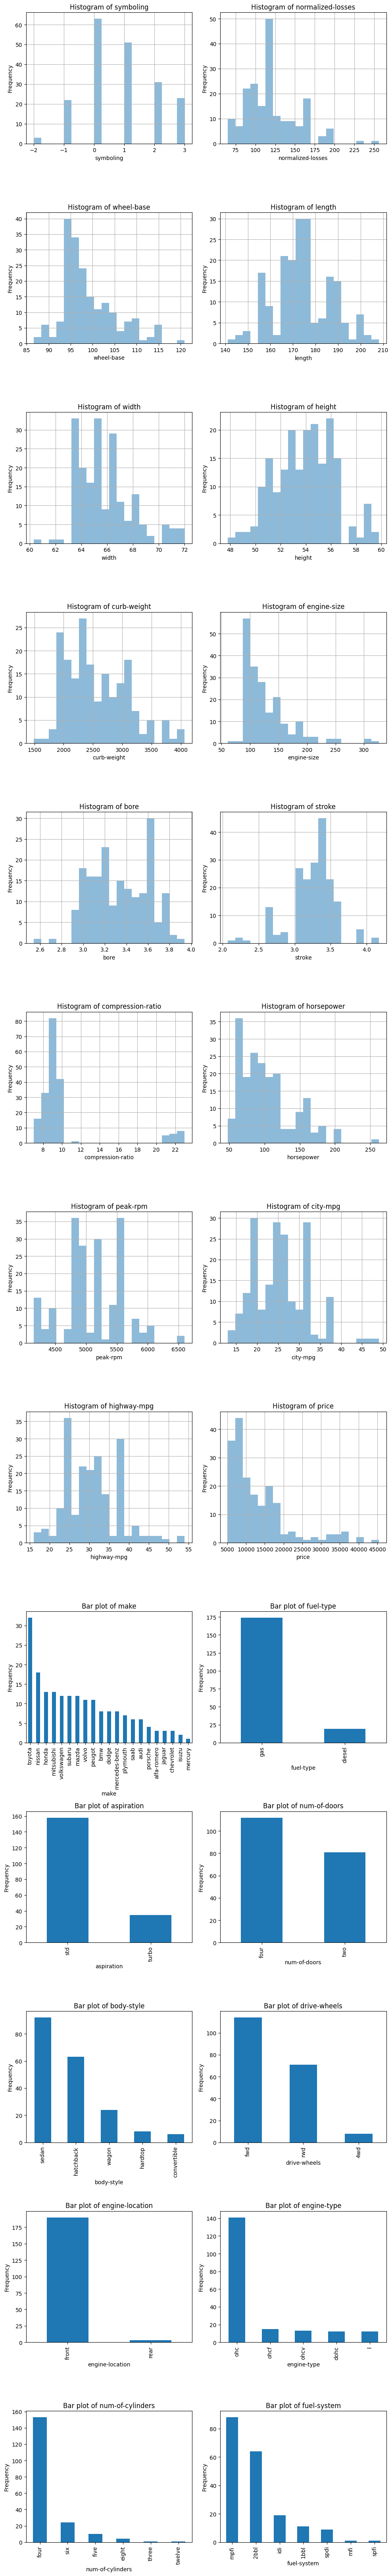

In [254]:
numerical_columns = Data.select_dtypes(exclude=['object']).columns.tolist()
nominal_columns = Data.select_dtypes(include=['object']).columns.tolist()

# Determine the number of rows and columns for subplots
num_numerical_plots = len(numerical_columns)
num_nominal_plots = len(nominal_columns)
total_plots = num_numerical_plots + num_nominal_plots
num_rows = total_plots // 2 + total_plots % 2
num_cols = 2

# Define the figure size based on the number of rows and columns
fig_width = 10
fig_height = 5 * num_rows

# Create a figure and axes objects for subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))

# Flatten the axes array if it's not already flat
axes = axes.flatten()

# Plot numerical columns
for i, column in enumerate(numerical_columns):
    Data[column].hist(ax=axes[i], alpha=0.5, bins=20)
    axes[i].set_xlabel(column)  # Set xlabel for the current column
    axes[i].set_ylabel('Frequency')  # Set ylabel
    axes[i].set_title(f'Histogram of {column}')  # Set title for the subplot

# Plot nominal columns
for j, column in enumerate(nominal_columns, start=i+1):
    Data[column].value_counts().plot(kind='bar', ax=axes[j])
    axes[j].set_xlabel(column)  # Set xlabel for the current column
    axes[j].set_ylabel('Frequency')  # Set ylabel
    axes[j].set_title(f'Bar plot of {column}')  # Set title for the subplot

# If the number of plots is odd, remove the last empty subplot
if total_plots % 2 != 0:
    fig.delaxes(axes[-1])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [255]:
#Created data set based on price
y = Data['price']
X = Data.drop(columns=['price'])

#split our data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [256]:
#transform categorical into nominal
onee = OneHotEncoder(handle_unknown='ignore')
transform = ColumnTransformer(transformers=[('one-hot', onee, ['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 'engine-location', 'engine-type', 'num-of-cylinders', 'fuel-system'])], remainder='passthrough')
transform.fit(X_train)

X_train_hot = pd.DataFrame(transform.transform(X_train), columns=transform.get_feature_names_out())
X_test_hot = pd.DataFrame(transform.transform(X_test), columns=transform.get_feature_names_out())

In [257]:
# Select best features
selector_MI = SelectKBest(mutual_info_regression, k=9)
selector_MI.fit_transform(X_train_hot, y_train)

array([[ 94.5, 165.3,  63.8, ...,  69. ,  31. ,  37. ],
       [ 93.7, 157.3,  63.8, ...,  68. ,  37. ,  41. ],
       [102.4, 175.6,  66.5, ...,  92. ,  27. ,  32. ],
       ...,
       [100.4, 181.7,  66.5, ..., 152. ,  17. ,  22. ],
       [100.4, 180.2,  66.9, ..., 110. ,  19. ,  24. ],
       [107.9, 186.7,  68.4, ...,  95. ,  19. ,  24. ]])

In [258]:
selector_MI.get_feature_names_out() # our best features

array(['remainder__wheel-base', 'remainder__length', 'remainder__width',
       'remainder__curb-weight', 'remainder__engine-size',
       'remainder__bore', 'remainder__horsepower', 'remainder__city-mpg',
       'remainder__highway-mpg'], dtype=object)

In [259]:
# Model selection with grid search
pipe3 = Pipeline([('select', SelectKBest()),('sc', StandardScaler()), ('reg', ElasticNet())])
param_grid = {'select__score_func': [mutual_info_regression, f_regression],
              'select__k': [8, 9], #paramater of our model and the range from which we can change
              'reg__alpha': [0.1, 0.5],
              'reg__l1_ratio': [0, 0.5, 1] #0 and 1 would be one of the limit cases
              }

grid_search = GridSearchCV(pipe3, param_grid, cv=5)
grid_search.fit(X_train_hot, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.903e+08, tolerance: 7.361e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.033e+08, tolerance: 5.355e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('select', SelectKBest()),
                                       ('sc', StandardScaler()),
                                       ('reg', ElasticNet())]),
             param_grid={'reg__alpha': [0.1, 0.5], 'reg__l1_ratio': [0, 0.5, 1],
                         'select__k': [8, 9],
                         'select__score_func': [<function mutual_info_regression at 0x7b4c0fb73eb0>,
                                                <function f_regression at 0x7b4c0fb713f0>]})

In [260]:
grid_search.best_estimator_[:-1].get_feature_names_out() #our best paramaters

array(['remainder__wheel-base', 'remainder__length', 'remainder__width',
       'remainder__curb-weight', 'remainder__engine-size',
       'remainder__horsepower', 'remainder__city-mpg',
       'remainder__highway-mpg'], dtype=object)

In [261]:
# train our model using the best features and the best model estimator
best_model = SGDRegressor(alpha=0.001, penalty='elasticnet')
best_features = selector_MI.get_feature_names_out().tolist() # best features based on MI
pipe = grid_search.best_estimator_ # best model

pipe.fit(X_train_hot,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.196e+08, tolerance: 8.171e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('select',
                 SelectKBest(k=8,
                             score_func=<function mutual_info_regression at 0x7b4c0fb73eb0>)),
                ('sc', StandardScaler()),
                ('reg', ElasticNet(alpha=0.1, l1_ratio=0))])

In [262]:
# Make a prediction for record 0 and compare it to the actual record
X_test.iloc[[0]]
X_test_hot[grid_search.best_estimator_[:-1].get_feature_names_out()].iloc[[0]]
pipe.predict(X_test_hot.iloc[[0]]), y_test.iloc[0]

(array([41921.97636896]), 36000.0)

# Results

As you can see our prediction model predicts 41921.98 whilst the actual record holds at 36000. It's not too far off meaning our model that was  trained on the best features performs well.